In [1]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [2]:
# Define transforms for images
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# need to subtract 1 from the make to bring it from 1-3 range to 0-2 range (CrossEntropyLoss requires labels to start from 0)
class SubtractOne(nn.Module):
  def forward(self, img):
    return img-1

# Define transforms for masks
target_transforms = transforms.Compose([                    ## Notice how we have a transform for the target (because it is an image) 
    transforms.Resize((256, 256)),                          ##        and another one for the image itself.  
    transforms.PILToTensor(),                               
    SubtractOne()                                           ## Question: What do you think would happen if we
                                                            ##  added rotation augmentation to the image only?
])


# Load train and test datasets
train_dataset = OxfordIIITPet(
    root='data/train/', split="trainval", target_types="segmentation", download=True,
    transform=img_transforms, target_transform=target_transforms
)

test_dataset = OxfordIIITPet(
    root='data/test/', split="test", target_types="segmentation", download=True,
    transform=img_transforms, target_transform=target_transforms
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train Dataset: {len(train_dataset)} images")
print(f"Test Dataset: {len(test_dataset)} images")

100%|██████████| 792M/792M [01:59<00:00, 6.61MB/s] 


Extracting data\train\oxford-iiit-pet\images.tar.gz to data\train\oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:03<00:00, 5.99MB/s]


Extracting data\train\oxford-iiit-pet\annotations.tar.gz to data\train\oxford-iiit-pet


100%|██████████| 792M/792M [01:24<00:00, 9.38MB/s] 


Extracting data\test\oxford-iiit-pet\images.tar.gz to data\test\oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 8.94MB/s]


Extracting data\test\oxford-iiit-pet\annotations.tar.gz to data\test\oxford-iiit-pet
Train Dataset: 3680 images
Test Dataset: 3669 images


# testing the model without training

In [3]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [train_dataset[0][0]]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
print(output)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\trh00/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


[{'boxes': tensor([[ 25.1080,  39.3945, 211.2831, 222.8359],
        [  0.0000,   3.3288, 136.2502, 113.6208],
        [  0.0000,  42.9583, 256.0000, 256.0000],
        [122.1213,   2.1879, 162.1491,  48.9031],
        [139.5661,   9.2979, 256.0000, 247.7101],
        [  0.0000,  91.9312,  96.0952, 246.2124],
        [  0.0000,   1.7181, 138.9422,  98.5425],
        [131.8399, 172.6117, 254.2360, 253.7375],
        [  0.0000,  13.7111, 115.1990, 246.9889],
        [157.7940, 181.7435, 241.7883, 253.7405],
        [  0.9381,   0.0000, 119.1624, 190.0590],
        [  0.0000,  11.3854, 148.4705, 189.1234],
        [ 43.3295, 145.8337, 256.0000, 251.9587],
        [  6.1746,   0.0000, 235.7068, 105.9861],
        [  3.0111,   5.4415, 136.0463, 178.7492],
        [  0.0000,  42.7478, 252.2100, 256.0000],
        [  1.9566,  51.3819, 117.4868, 245.3530],
        [  4.4699,  39.9140, 121.6835, 241.5437],
        [  1.5616,   4.1733, 128.0985, 129.8273],
        [  0.3227,   0.0000, 233.6595, 

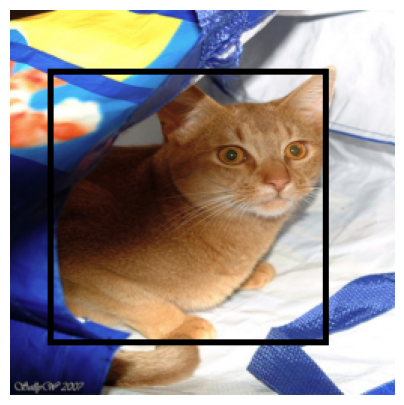

In [18]:
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def show(imgs):
    
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(5 * len(imgs), 5))
    
    for i, img in enumerate(imgs):
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
    
    plt.show()

score_threshold = .8
# dogs_with_boxes = [
#     draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
#     for dog_int, output in zip(dog_list, outputs)
# ]
pet_with_boxes = draw_bounding_boxes(train_dataset[0][0], boxes=output[0]['boxes'][output[0]['scores'] > score_threshold], width=4)
show(pet_with_boxes)

shape = torch.Size([21, 1, 256, 256]), dtype = torch.bool


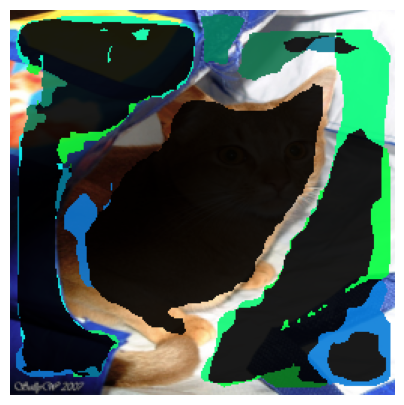

In [21]:
from torchvision.utils import draw_segmentation_masks
proba_threshold = 0.9
cat_bool_masks = output[0]['masks'] > proba_threshold
print(f"shape = {cat_bool_masks.shape}, dtype = {cat_bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
cat_bool_masks = cat_bool_masks.squeeze(1)

show(draw_segmentation_masks(train_dataset[0][0], cat_bool_masks, alpha=0.9))